# BaarleNet [Part 7c - baby loss landsacpes]

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def save_viz(model, save_path=None):
    plt.clf()
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    
    h1 = model.model[:2](torch.tensor(probe).float())
    h1 = h1.detach().numpy().reshape(100,100,3)

    h2 = model.model[:3](torch.tensor(probe).float())
    h2 = h2.detach().numpy().reshape(100,100,2)
        
    # First neuron (output index 0)
    j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
    j1 = denorm(np.array(j1)) if j1 else []
    
    # Second neuron (output index 1)  
    j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
    j2 = denorm(np.array(j2)) if j2 else []
    
    j3 = get_relu_joint(model.model[0].weight[2,0].item(), model.model[0].weight[2,1].item(), model.model[0].bias[2].item(), extent=1)
    j3 = denorm(np.array(j3)) if j3 else []
    
    fig=plt.figure(0,(10,10)); 
    for i in range(3):
        ax=fig.add_subplot(2,2,i+1)
        ax.imshow(map.mean(2), cmap='gray')
        ax.imshow(np.flipud(h1[:,:,i]>0), 
                   extent=[0, 960, 960, 0],  # This maps to image coordinates
                   alpha=0.7,
                   cmap='viridis')
        if i==0 and len(j1)>0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
        if i==1 and len(j2)>0: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)
        if i==2 and len(j3)>0: ax.plot([j3[0][0], j3[1][0]], [j3[0][1], j3[1][1]], '--', color='#FFFFFF', linewidth=2)
    
    ax=fig.add_subplot(2,2,4)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    # ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
    #            extent=[0, 960, 960, 0],  # This maps to image coordinates
    #            alpha=0.7,
    #            cmap='viridis')
    
    ax.imshow(np.flipud((h2[:,:,1]-h2[:,:,0])>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if save_path is not None: plt.savefig(save_path)

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

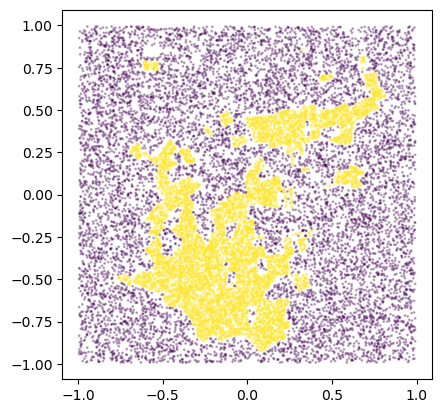

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [5]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
import pickle
import copy
import os

## Run same loop, but save best and worst

In [44]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Training parameters
num_epochs = 2500
num_seeds = 8 #8 is nice for quick tests

# Configure output directory
output_dir = "/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2"  # Change this to your desired directory
os.makedirs(output_dir, exist_ok=True)
print(f"Saving results to: {output_dir}")

# Track best and worst models
best_model_data = {'accuracy': -1, 'seed': None, 'initial_params': None, 'final_params': None}
worst_model_data = {'accuracy': float('inf'), 'seed': None, 'initial_params': None, 'final_params': None}

for seed_idx in range(num_seeds):
    random_seed = seed_idx  # You can change this to any seed generation logic
    torch.manual_seed(random_seed)
    
    # Initialize model and optimizer
    model = BaarleNet([3]) #[3] is probaby the move for this
    print(model.model[0].weight)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Store initial parameters (deep copy)
    initial_params = {}
    for name, param in model.named_parameters():
        initial_params[name] = param.data.clone()
    
    # Data storage for this run
    training_data = {
        'seed': random_seed,
        'weights_history': [],
        'gradients_history': [],
        'xy_history': [],
        'loss_history': [],
        'accuracy_history': [],
        'initial_params': initial_params  # Store initial params in training data too
    }

    print(f"\n=== Training with seed {random_seed} ===")

    for epoch in range(num_epochs):
        # Get current data point
        current_idx = epoch % len(y)
        # Stochastic
        # current_x = torch.tensor(X[current_idx]).float()
        # current_y = torch.tensor(y[current_idx])

        #Try batch for a second
        current_x = torch.tensor(X).float()
        current_y = torch.tensor(y)  
        
        # Forward pass
        outputs = model(current_x)
        loss = criterion(outputs, current_y)
        if epoch==0:
            print('initial loss = ', loss.item())
        
        # Store current X,y values
        training_data['xy_history'].append({
            'epoch': epoch,
            'x': X[current_idx].copy(),
            'y': y[current_idx]
        })
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Store model weights (deep copy to avoid reference issues)
        current_weights = {}
        for name, param in model.named_parameters():
            current_weights[name] = param.data.clone()
        training_data['weights_history'].append(current_weights)
        
        # Store model gradients (deep copy)
        current_gradients = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                current_gradients[name] = param.grad.clone()
            else:
                current_gradients[name] = None
        training_data['gradients_history'].append(current_gradients)
        
        # Update parameters
        optimizer.step()
        
        # Store loss
        training_data['loss_history'].append(loss.item())
        
        # Calculate and store accuracy periodically
        if (epoch + 1) % (num_epochs // 25) == 0:
            with torch.no_grad():
                outputs_batch = model(X_tensor)
                accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
                training_data['accuracy_history'].append({
                    'epoch': epoch,
                    'accuracy': accuracy
                })
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    # Calculate final accuracy
    with torch.no_grad():
        final_outputs = model(X_tensor)
        final_accuracy = (torch.argmax(final_outputs, dim=1) == y_tensor).sum().item() / len(y)
    
    # Store final parameters (deep copy)
    final_params = {}
    for name, param in model.named_parameters():
        final_params[name] = param.data.clone()
    
    # Check if this is the best or worst model so far
    if final_accuracy > best_model_data['accuracy']:
        best_model_data = {
            'accuracy': final_accuracy,
            'seed': random_seed,
            'initial_params': {name: param.clone() for name, param in initial_params.items()},
            'final_params': {name: param.clone() for name, param in final_params.items()}
        }
        print(f"*** NEW BEST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
    if final_accuracy < worst_model_data['accuracy']:
        worst_model_data = {
            'accuracy': final_accuracy,
            'seed': random_seed,
            'initial_params': {name: param.clone() for name, param in initial_params.items()},
            'final_params': {name: param.clone() for name, param in final_params.items()}
        }
        print(f"*** NEW WORST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
    # Save data as pickle file
    filename = os.path.join(output_dir, f"training_data_seed_{random_seed:02d}_acc_{final_accuracy:.4f}.pkl")
    
    # Add final accuracy and params to the data
    training_data['final_accuracy'] = final_accuracy
    training_data['final_model_state'] = model.state_dict()
    training_data['final_params'] = final_params
    
    with open(filename, 'wb') as f:
        pickle.dump(training_data, f)
    
    print(f"Saved training data to {filename}")
    print(f"Final accuracy: {final_accuracy:.4f}")

    # Restore initial weights for visualization
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = training_data['weights_history'][0][name]

    print(model.model[0].weight)
    viz_fn = os.path.join(output_dir, f"{final_accuracy:.4f}_random_init.png")
    # save_viz(model, str(viz_fn))

# After all training is complete, save best and worst model data
best_worst_data = {
    'best_model': best_model_data,
    'worst_model': worst_model_data
}

best_worst_filename = os.path.join(output_dir, "best_worst_models.pkl")
with open(best_worst_filename, 'wb') as f:
    pickle.dump(best_worst_data, f)

print(f"\n=== FINAL RESULTS ===")
print(f"Best model: Seed {best_model_data['seed']}, Accuracy {best_model_data['accuracy']:.4f}")
print(f"Worst model: Seed {worst_model_data['seed']}, Accuracy {worst_model_data['accuracy']:.4f}")
print(f"Best/worst model data saved to: {best_worst_filename}")

Saving results to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2
Parameter containing:
tensor([[-0.0053,  0.3793],
        [-0.5820, -0.5204],
        [-0.2723,  0.1896]], requires_grad=True)

=== Training with seed 0 ===
initial loss =  0.6881574392318726
Epoch [100/2500], Loss: 0.5164, Accuracy: 0.7867
Epoch [200/2500], Loss: 0.3821, Accuracy: 0.8463
Epoch [300/2500], Loss: 0.3623, Accuracy: 0.8493
Epoch [400/2500], Loss: 0.3605, Accuracy: 0.8490
Epoch [500/2500], Loss: 0.3603, Accuracy: 0.8495
Epoch [600/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [700/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [800/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [900/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1000/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1100/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1200/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1300/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1400/2500], Loss: 0.3602, Accuracy: 0.8494
Epoch [1500

In [9]:
print(f"\n=== FINAL RESULTS ===")
print(f"Best model: Seed {best_model_data['seed']}, Accuracy {best_model_data['accuracy']:.4f}")
print(f"Worst model: Seed {worst_model_data['seed']}, Accuracy {worst_model_data['accuracy']:.4f}")
print(f"Best/worst model data saved to: {best_worst_filename}")


=== FINAL RESULTS ===
Best model: Seed 2, Accuracy 0.7746
Worst model: Seed 7, Accuracy 0.5000
Best/worst model data saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/best_worst_models.pkl


In [10]:
best_model_data

{'accuracy': 0.7746,
 'seed': 2,
 'initial_params': {'model.0.weight': tensor([[ 0.1622, -0.1683],
          [ 0.1939, -0.0361]]),
  'model.0.bias': tensor([0.3021, 0.1683]),
  'model.2.weight': tensor([[-0.0813, -0.5717],
          [ 0.1614, -0.6260]]),
  'model.2.bias': tensor([0.0929, 0.0470])},
 'final_params': {'model.0.weight': tensor([[ 0.9939, -0.9577],
          [ 3.4115, -1.6025]]),
  'model.0.bias': tensor([ 1.9486, -1.4388]),
  'model.2.weight': tensor([[-1.2461,  2.4383],
          [ 1.3263, -3.6360]]),
  'model.2.bias': tensor([ 2.1952, -2.0552])}}

In [11]:
worst_model_data

{'accuracy': 0.5,
 'seed': 7,
 'initial_params': {'model.0.weight': tensor([[ 0.0494, -0.4260],
          [ 0.2252,  0.2219]]),
  'model.0.bias': tensor([-0.3779, -0.1060]),
  'model.2.weight': tensor([[-0.4142,  0.1835],
          [-0.1905,  0.4968]]),
  'model.2.bias': tensor([0.5020, 0.0720])},
 'final_params': {'model.0.weight': tensor([[-0.0472, -0.3331],
          [ 0.0286,  0.0351]]),
  'model.0.bias': tensor([-0.4703, -0.2999]),
  'model.2.weight': tensor([[-0.3323,  0.3483],
          [-0.2724,  0.3320]]),
  'model.2.bias': tensor([0.2870, 0.2870])}}

## Loss Landscape Contour Plot

In [45]:
def load_best_worst_data(filepath):
    """Load the best and worst model data"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['best_model'], data['worst_model']

def interpolate_weights(weights1, weights2, alpha):
    """
    Interpolate between two weight dictionaries
    alpha = 0: returns weights1
    alpha = 1: returns weights2
    """
    interpolated = {}
    for name in weights1.keys():
        interpolated[name] = (1 - alpha) * weights1[name] + alpha * weights2[name]
    return interpolated

def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()

def create_loss_landscape_2d(best_model_data, worst_model_data, X_tensor, y_tensor, 
                           model_class, model_args, resolution=50, output_dir=None):
    """
    Create 2D loss landscape visualization
    
    Dimension 1 (x-axis): Best model initial -> Best model final
    Dimension 2 (y-axis): Worst model initial -> Best model final
    """
    
    # Create a fresh model for evaluation
    model = model_class(model_args)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Create interpolation grids
    alphas = np.linspace(0, 1, resolution)
    betas = np.linspace(0, 1, resolution)
    
    # Initialize loss landscape
    loss_landscape = np.zeros((resolution, resolution))
    
    print("Computing loss landscape...")
    
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            # Create a proper 2D interpolation grid
            # We want to interpolate between 4 corner points:
            # (0,0) = best_initial
            # (1,0) = best_final  
            # (0,1) = worst_initial
            # (1,1) = worst_final
            
            # Use bilinear interpolation
            # First interpolate along the bottom edge (beta=0): best_initial -> best_final
            bottom_edge = interpolate_weights(
                best_model_data['initial_params'],
                best_model_data['final_params'], 
                alpha
            )
            
            # Then interpolate along the top edge (beta=1): worst_initial -> best_final
            top_edge = interpolate_weights(
                worst_model_data['initial_params'],
                # best_model_data['final_params'],
                worst_model_data['final_params'], #SW Mod
                alpha
            )
            
            # Finally interpolate between bottom and top edges
            final_weights = interpolate_weights(bottom_edge, top_edge, beta)
            
            # Set model weights and compute loss
            set_model_weights(model, final_weights)
            loss = compute_loss_at_point(model, X_tensor, y_tensor, criterion)
            loss_landscape[j, i] = loss
        
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution}")
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Create contour plot
    X, Y = np.meshgrid(alphas, betas)
    contour = plt.contour(X, Y, loss_landscape, levels=20, colors='black', alpha=0.6, linewidths=0.8)
    contourf = plt.contourf(X, Y, loss_landscape, levels=50, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(contourf)
    cbar.set_label('Loss', fontsize=12)
    
    # Add contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Mark key points
    plt.plot(0, 0, 'ro', markersize=10, label=f'Best Initial (Acc: {best_model_data["accuracy"]:.3f})')
    plt.plot(1, 0, 'go', markersize=10, label=f'Best Final (Acc: {best_model_data["accuracy"]:.3f})')  
    plt.plot(0, 1, 'bo', markersize=10, label=f'Worst Initial (Acc: {worst_model_data["accuracy"]:.3f})')
    plt.plot(1, 1, 'go', markersize=8, alpha=0.7)  # Same as best final
    
    # Add arrows to show the training trajectories
    plt.annotate('', xy=(1, 0), xytext=(0, 0), 
                arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7),
                label='Best model training path')
    
    # Labels and title
    plt.xlabel('Best Model: Initial → Final', fontsize=12)
    plt.ylabel('Worst Initial → Best Final', fontsize=12)
    plt.title('2D Loss Landscape\nInterpolating Between Key Weight Configurations', fontsize=14)
    
    # Legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output directory specified
    if output_dir:
        viz_path = os.path.join(output_dir, 'loss_landscape_2d.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"Loss landscape saved to: {viz_path}")
    
    plt.show()
    
    return loss_landscape, alphas, betas

In [46]:
worst_model_data

{'accuracy': 0.6556,
 'seed': 2,
 'initial_params': {'model.0.weight': tensor([[ 0.1622, -0.1683],
          [ 0.1939, -0.0361],
          [ 0.3021,  0.1683]]),
  'model.0.bias': tensor([-0.0813, -0.5717,  0.1614]),
  'model.2.weight': tensor([[-0.5112,  0.0759,  0.0384],
          [-0.1270,  0.4721,  0.0385]]),
  'model.2.bias': tensor([0.2394, 0.2443])},
 'final_params': {'model.0.weight': tensor([[ 0.0036, -0.0353],
          [ 0.1939, -0.0361],
          [-0.8551,  2.6101]]),
  'model.0.bias': tensor([-0.2621, -0.5717, -0.9384]),
  'model.2.weight': tensor([[-0.3622,  0.0759,  1.8118],
          [-0.2759,  0.4721, -1.7349]]),
  'model.2.bias': tensor([0.0445, 0.4393])}}

In [47]:
best_model_data

{'accuracy': 0.8504,
 'seed': 7,
 'initial_params': {'model.0.weight': tensor([[ 0.0494, -0.4260],
          [ 0.2252,  0.2219],
          [-0.3779, -0.1060]]),
  'model.0.bias': tensor([-0.4142,  0.1835, -0.1905]),
  'model.2.weight': tensor([[ 0.4056,  0.4099,  0.0588],
          [-0.2461, -0.3391, -0.0634]]),
  'model.2.bias': tensor([-0.1625,  0.2545])},
 'final_params': {'model.0.weight': tensor([[ 1.5767, -2.1672],
          [ 2.5994,  0.8628],
          [-3.0507,  1.0414]]),
  'model.0.bias': tensor([0.1390, 1.0909, 1.5480]),
  'model.2.weight': tensor([[ 2.4002,  2.1183,  2.2776],
          [-2.2407, -2.0475, -2.2822]]),
  'model.2.bias': tensor([-7.4114,  7.5034])}}

Computing loss landscape...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13095/3818586867.py:121: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))


Loss landscape saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/loss_landscape_2d.png


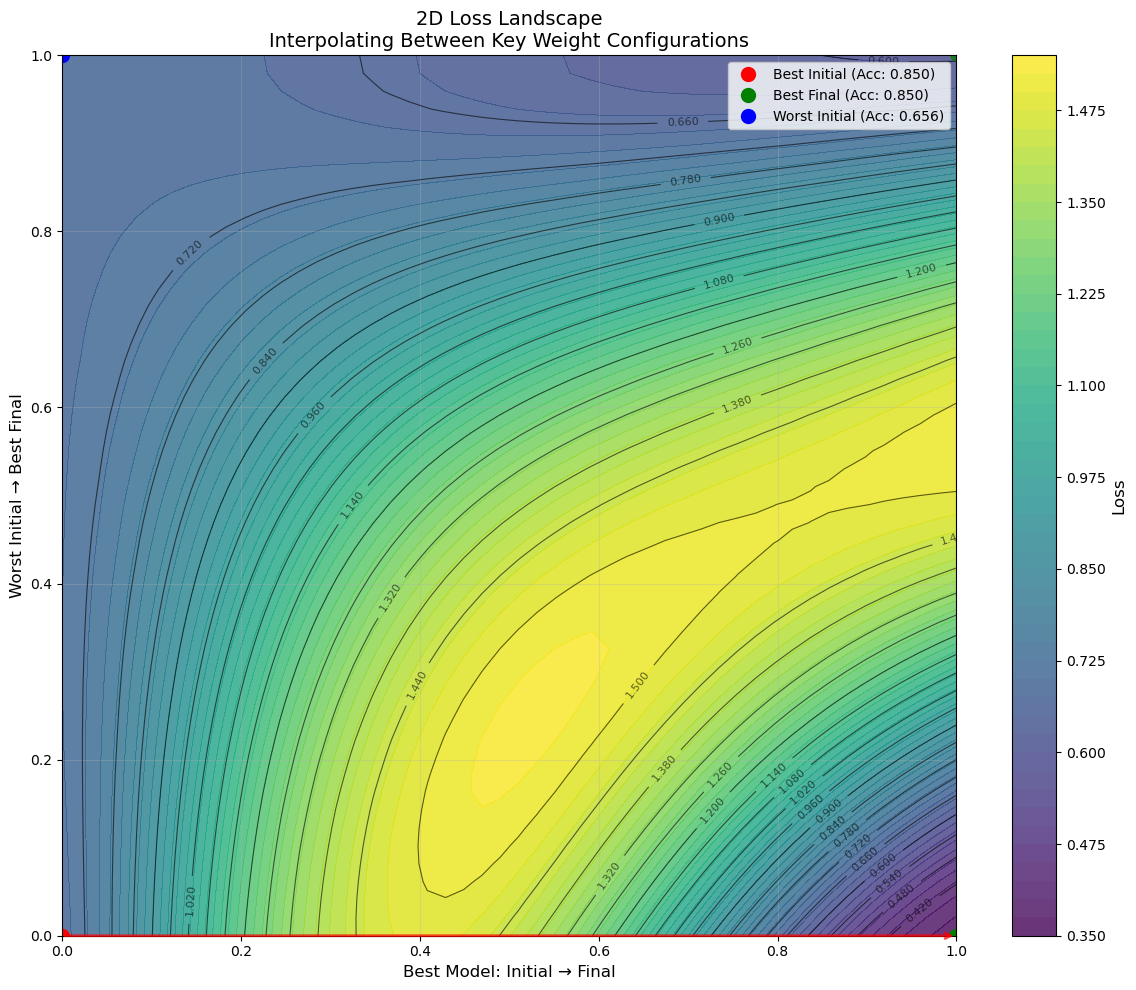

In [48]:
loss_landscape, alphas, betas = create_loss_landscape_2d(
    best_model_data, 
    worst_model_data, 
    X_tensor, 
    y_tensor,
    BaarleNet,  # Your model class
    [3],        # Your model args
    resolution=50,
    output_dir=output_dir
)

- Hmm hmm so we're doing stochastic gradient descent here
- I'm very surprised by the loss values -> they dont' quite make sense to me.
- If this loss landscape is right, then the initial config for bad performing configs have as low of loss as a final good solution?
- Now way that's right, right?

In [16]:
best_model_data

{'accuracy': 0.7746,
 'seed': 2,
 'initial_params': {'model.0.weight': tensor([[ 0.1622, -0.1683],
          [ 0.1939, -0.0361]]),
  'model.0.bias': tensor([0.3021, 0.1683]),
  'model.2.weight': tensor([[-0.0813, -0.5717],
          [ 0.1614, -0.6260]]),
  'model.2.bias': tensor([0.0929, 0.0470])},
 'final_params': {'model.0.weight': tensor([[ 0.9939, -0.9577],
          [ 3.4115, -1.6025]]),
  'model.0.bias': tensor([ 1.9486, -1.4388]),
  'model.2.weight': tensor([[-1.2461,  2.4383],
          [ 1.3263, -3.6360]]),
  'model.2.bias': tensor([ 2.1952, -2.0552])}}

In [17]:
set_model_weights(model, best_model_data['initial_params'])
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.6912224292755127

In [18]:
save_viz(model)

ValueError: cannot reshape array of size 20000 into shape (100,100,3)

<Figure size 640x480 with 0 Axes>

In [19]:
set_model_weights(model, best_model_data['final_params'])
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.47520917654037476

In [ ]:
save_viz(model)

In [28]:
set_model_weights(model, worst_model_data['initial_params'])
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.7168412804603577

In [29]:
set_model_weights(model, worst_model_data['final_params'])
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.6931473612785339

In [ ]:
best_model_data['initial_params']

In [ ]:
best_model_data['final_params']

In [38]:
mid_weights=interpolate_weights(best_model_data['initial_params'], best_model_data['final_params'], 0.1)

In [39]:
set_model_weights(model, mid_weights)
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.6875439882278442

In [32]:
mid_weights=interpolate_weights(worst_model_data['initial_params'], best_model_data['final_params'], 0.5)

In [33]:
set_model_weights(model, mid_weights)
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

0.7962325215339661

Hmm ok all of that passes the smell test so far....final random seed I'm trying here works pretty well - won't be true if I increase the number of trials!

In [ ]:
training_data.keys()

In [ ]:
training_data['accuracy_history']

In [ ]:
training_data['gradients_history']

## Ok PCA? 

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def flatten_weight_dict(weight_dict):
    """
    Flatten a dictionary of weight tensors into a single 1D numpy array
    """
    flattened = []
    for name, tensor in weight_dict.items():
        if tensor is not None:
            flattened.append(tensor.cpu().numpy().flatten())
    return np.concatenate(flattened)

def unflatten_to_weight_dict(flattened_weights, reference_dict):
    """
    Convert flattened weights back to the original dictionary structure
    """
    result = {}
    start_idx = 0
    
    for name, tensor in reference_dict.items():
        if tensor is not None:
            shape = tensor.shape
            size = tensor.numel()
            
            # Extract the portion for this parameter
            param_weights = flattened_weights[start_idx:start_idx + size]
            
            # Reshape and convert to tensor
            result[name] = torch.tensor(param_weights.reshape(shape)).float()
            start_idx += size
    
    return result

def create_weight_history_matrix(training_data):
    """
    Convert weight history to a matrix where each row is a time step
    and each column is a flattened weight parameter
    """
    weights_history = training_data['weights_history']
    
    # Flatten each time step
    weight_matrix = []
    for weights in weights_history:
        flattened = flatten_weight_dict(weights)
        weight_matrix.append(flattened)
    
    return np.array(weight_matrix)

def compute_pca_directions(model_filepath, model_name="model"):
    """
    Load model training data and compute PCA directions
    """
    # Load the model's training data
    with open(model_filepath, 'rb') as f:
        training_data = pickle.load(f)
    
    print(f"Loaded {model_name} training data for seed {training_data['seed']}")
    print(f"Final accuracy: {training_data['final_accuracy']:.4f}")
    
    # Convert weight history to matrix
    weight_matrix = create_weight_history_matrix(training_data)
    print(f"{model_name} weight matrix shape: {weight_matrix.shape}")
    
    # Center the data (subtract mean)
    weight_mean = np.mean(weight_matrix, axis=0)
    centered_weights = weight_matrix - weight_mean
    
    # Apply PCA
    pca = PCA()
    pca.fit(centered_weights)
    
    # Get the first principal component
    pc1 = pca.components_[0]
    
    print(f"{model_name} explained variance ratio:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
    
    return pc1, weight_mean, training_data, pca

def create_dual_pca_loss_landscape(best_pc1, worst_pc1, best_weight_mean, worst_weight_mean, 
                                  reference_weights, X_tensor, y_tensor, model_class, model_args,
                                  best_training_data, worst_training_data, resolution=50, output_dir=None):
    """
    Create loss landscape using first PCA direction from each model
    
    Args:
        best_pc1: First PC direction from best model
        worst_pc1: First PC direction from worst model  
        best_weight_mean, worst_weight_mean: Mean weight vectors from each model
        reference_weights: Reference weight dict for unflattening
        best_training_data, worst_training_data: Training data for both models
        resolution: Grid resolution
    """
    
    # Create model for evaluation
    model = model_class(model_args)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Project training trajectories to determine ranges
    best_weight_matrix = create_weight_history_matrix(best_training_data)
    worst_weight_matrix = create_weight_history_matrix(worst_training_data)
    
    # Center each trajectory using its own mean
    best_centered = best_weight_matrix - best_weight_mean
    worst_centered = worst_weight_matrix - worst_weight_mean
    
    # Project onto respective first PCs
    best_pc1_proj = np.dot(best_centered, best_pc1)
    worst_pc1_proj = np.dot(worst_centered, worst_pc1)
    
    print(f"Best model PC1 projection range: [{best_pc1_proj.min():.2f}, {best_pc1_proj.max():.2f}]")
    print(f"Worst model PC1 projection range: [{worst_pc1_proj.min():.2f}, {worst_pc1_proj.max():.2f}]")
    
    # Determine ranges with padding
    best_padding = (best_pc1_proj.max() - best_pc1_proj.min()) * 0.2
    worst_padding = (worst_pc1_proj.max() - worst_pc1_proj.min()) * 0.2
    
    best_range = np.linspace(best_pc1_proj.min() - best_padding, 
                            best_pc1_proj.max() + best_padding, resolution)
    worst_range = np.linspace(worst_pc1_proj.min() - worst_padding, 
                             worst_pc1_proj.max() + worst_padding, resolution)
    
    print(f"Loss landscape ranges:")
    print(f"X-axis (Best PC1): [{best_range[0]:.2f}, {best_range[-1]:.2f}]")
    print(f"Y-axis (Worst PC1): [{worst_range[0]:.2f}, {worst_range[-1]:.2f}]")
    
    # Initialize loss landscape
    loss_landscape = np.zeros((resolution, resolution))
    
    print("Computing dual-PCA loss landscape...")
    
    # We need a common reference point for interpolation
    # Use the average of the two weight means as our reference
    reference_mean = (best_weight_mean + worst_weight_mean) / 2
    
    for i, alpha in enumerate(best_range):
        for j, beta in enumerate(worst_range):
            # Create weight vector by moving along both PC directions from reference
            weight_vector = reference_mean + alpha * best_pc1 + beta * worst_pc1
            
            # Convert back to weight dictionary format
            weight_dict = unflatten_to_weight_dict(weight_vector, reference_weights)
            
            # Set model weights and compute loss
            set_model_weights(model, weight_dict)
            loss = compute_loss_at_point(model, X_tensor, y_tensor, criterion)
            loss_landscape[j, i] = loss
        
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution}")
    
    return loss_landscape, best_range, worst_range, best_pc1_proj, worst_pc1_proj, reference_mean

def plot_dual_pca_loss_landscape(loss_landscape, best_range, worst_range, 
                               best_pc1_proj, worst_pc1_proj, best_training_data, worst_training_data,
                               best_pca, worst_pca, reference_mean, best_pc1, worst_pc1,
                               output_dir=None):
    """
    Plot the dual-PCA loss landscape with both training trajectories
    """
    plt.figure(figsize=(16, 12))
    
    # Create meshgrid
    X, Y = np.meshgrid(best_range, worst_range)
    
    # Create contour plot
    contour = plt.contour(X, Y, loss_landscape, levels=20, colors='black', alpha=0.6, linewidths=0.8)
    contourf = plt.contourf(X, Y, loss_landscape, levels=50, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(contourf)
    cbar.set_label('Loss', fontsize=12)
    
    # Add contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # For trajectory plotting, we need to project both models onto the dual PC space
    # Best model trajectory along x-axis (its own PC1)
    best_weight_matrix = create_weight_history_matrix(best_training_data)
    best_centered = best_weight_matrix - (best_weight_matrix.mean(axis=0))
    best_x_proj = np.dot(best_centered, best_pc1)
    
    # To get best model's y-coordinates, project its trajectory onto worst model's PC1
    best_y_proj = np.dot(best_centered, worst_pc1)
    
    # Worst model trajectory along y-axis (its own PC1)  
    worst_weight_matrix = create_weight_history_matrix(worst_training_data)
    worst_centered = worst_weight_matrix - (worst_weight_matrix.mean(axis=0))
    worst_y_proj = np.dot(worst_centered, worst_pc1)
    
    # To get worst model's x-coordinates, project its trajectory onto best model's PC1
    worst_x_proj = np.dot(worst_centered, best_pc1)
    
    # Plot best model training trajectory
    plt.plot(best_x_proj, best_y_proj, 'r-', linewidth=3, alpha=0.8, 
            label=f'Best Model Training (Seed {best_training_data["seed"]})')
    plt.plot(best_x_proj[0], best_y_proj[0], 'ro', markersize=12, 
            label=f'Best Initial (Acc: {best_training_data["final_accuracy"]:.3f})')
    plt.plot(best_x_proj[-1], best_y_proj[-1], 'go', markersize=12, 
            label=f'Best Final (Acc: {best_training_data["final_accuracy"]:.3f})')
    
    # Plot worst model training trajectory
    plt.plot(worst_x_proj, worst_y_proj, 'b-', linewidth=3, alpha=0.8, 
            label=f'Worst Model Training (Seed {worst_training_data["seed"]})')
    plt.plot(worst_x_proj[0], worst_y_proj[0], 'bo', markersize=12, 
            label=f'Worst Initial (Acc: {worst_training_data["final_accuracy"]:.3f})')
    plt.plot(worst_x_proj[-1], worst_y_proj[-1], 'mo', markersize=12, 
            label=f'Worst Final (Acc: {worst_training_data["final_accuracy"]:.3f})')
    
    # Add some intermediate points
    trajectory_points = [len(best_x_proj)//4, len(best_x_proj)//2, 3*len(best_x_proj)//4]
    for point_idx in trajectory_points:
        plt.plot(best_x_proj[point_idx], best_y_proj[point_idx], 'yo', markersize=4, alpha=0.6)
        plt.plot(worst_x_proj[point_idx], worst_y_proj[point_idx], 'co', markersize=4, alpha=0.6)
    
    # Labels and title
    best_var = best_pca.explained_variance_ratio_[0]
    worst_var = worst_pca.explained_variance_ratio_[0]
    
    plt.xlabel(f'Best Model PC1 ({best_var:.1%} of best model variance)', fontsize=14)
    plt.ylabel(f'Worst Model PC1 ({worst_var:.1%} of worst model variance)', fontsize=14)
    plt.title(f'Loss Landscape: Best Model PC1 vs Worst Model PC1\nOrthogonal Primary Optimization Directions', fontsize=16)
    
    # Legend
    plt.legend(loc='best', fontsize=10)
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output directory specified
    if output_dir:
        viz_path = os.path.join(output_dir, 'loss_landscape_dual_pca.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"Dual PCA loss landscape saved to: {viz_path}")
    
    plt.show()
    
    return best_x_proj, best_y_proj, worst_x_proj, worst_y_proj

def compare_models_in_pca_space(best_model_data, worst_model_data, pc1, pc2, weight_mean):
    """
    Project best and worst model initial/final weights onto PCA space
    """
    models_to_compare = [
        ('Best Initial', best_model_data['initial_params'], 'ro'),
        ('Best Final', best_model_data['final_params'], 'go'), 
        ('Worst Initial', worst_model_data['initial_params'], 'bo'),
        ('Worst Final', worst_model_data['final_params'], 'mo')
    ]
    
    projections = {}
    
    for name, weights, marker in models_to_compare:
        # Flatten and center
        flattened = flatten_weight_dict(weights)
        centered = flattened - weight_mean
        
        # Project onto PCs
        pc1_proj = np.dot(centered, pc1)
        pc2_proj = np.dot(centered, pc2)
        
        projections[name] = (pc1_proj, pc2_proj)
        print(f"{name}: PC1={pc1_proj:.3f}, PC2={pc2_proj:.3f}")
    
    return projections

# Set model weights function (reused from previous code)
def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()

# Main execution function
def run_dual_pca_analysis(output_dir, X_tensor, y_tensor, model_class, model_args):
    """
    Complete dual-PCA analysis workflow
    """
    # Load best/worst model data
    best_worst_file = os.path.join(output_dir, "best_worst_models.pkl")
    with open(best_worst_file, 'rb') as f:
        data = pickle.load(f)
    best_model_data = data['best_model']
    worst_model_data = data['worst_model']
    
    # Find the training files
    best_seed = best_model_data['seed']
    best_acc = best_model_data['accuracy']
    best_model_file = os.path.join(output_dir, f"training_data_seed_{best_seed:02d}_acc_{best_acc:.4f}.pkl")
    
    worst_seed = worst_model_data['seed']
    worst_acc = worst_model_data['accuracy']
    worst_model_file = os.path.join(output_dir, f"training_data_seed_{worst_seed:02d}_acc_{worst_acc:.4f}.pkl")
    
    print(f"Loading best model training data from: {best_model_file}")
    print(f"Loading worst model training data from: {worst_model_file}")
    
    # Compute PCA directions from each model's training trajectory
    best_pc1, best_weight_mean, best_training_data, best_pca = compute_pca_directions(best_model_file, "Best")
    worst_pc1, worst_weight_mean, worst_training_data, worst_pca = compute_pca_directions(worst_model_file, "Worst")
    
    print(f"\nPCA Analysis Summary:")
    print(f"Best model PC1 captures {best_pca.explained_variance_ratio_[0]:.1%} of its training variance")
    print(f"Worst model PC1 captures {worst_pca.explained_variance_ratio_[0]:.1%} of its training variance")
    
    # Create dual-PCA loss landscape
    results = create_dual_pca_loss_landscape(
        best_pc1, worst_pc1, best_weight_mean, worst_weight_mean,
        best_training_data['initial_params'], X_tensor, y_tensor, 
        model_class, model_args, best_training_data, worst_training_data,
        resolution=50, output_dir=output_dir
    )
    
    loss_landscape, best_range, worst_range, best_pc1_proj, worst_pc1_proj, reference_mean = results
    
    # Plot the results
    trajectory_projections = plot_dual_pca_loss_landscape(
        loss_landscape, best_range, worst_range, 
        best_pc1_proj, worst_pc1_proj, best_training_data, worst_training_data,
        best_pca, worst_pca, reference_mean, best_pc1, worst_pc1,
        output_dir=output_dir
    )
    
    print(f"\nAnalysis complete! Both models should now show meaningful variation along their respective axes.")
    
    return {
        'best_pc1': best_pc1,
        'worst_pc1': worst_pc1,
        'best_pca': best_pca,
        'worst_pca': worst_pca,
        'loss_landscape': loss_landscape,
        'best_range': best_range,
        'worst_range': worst_range,
        'trajectory_projections': trajectory_projections,
        'reference_mean': reference_mean
    }

Loading best model training data from: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/training_data_seed_02_acc_0.7746.pkl
Loading worst model training data from: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/training_data_seed_07_acc_0.5000.pkl
Loaded Best training data for seed 2
Final accuracy: 0.7746
Best weight matrix shape: (2500, 12)
Best explained variance ratio:
PC1: 0.9371
Loaded Worst training data for seed 7
Final accuracy: 0.5000
Worst weight matrix shape: (2500, 12)
Worst explained variance ratio:
PC1: 0.9841

PCA Analysis Summary:
Best model PC1 captures 93.7% of its training variance
Worst model PC1 captures 98.4% of its training variance
Best model PC1 projection range: [-0.65, 6.28]
Worst model PC1 projection range: [-0.01, 0.54]
Loss landscape ranges:
X-axis (Best PC1): [-2.04, 7.66]
Y-axis (Worst PC1): [-0.13, 0.65]
Computing dual-PCA loss landscape...
Progress: 0/50
Progress: 10/50
Pro

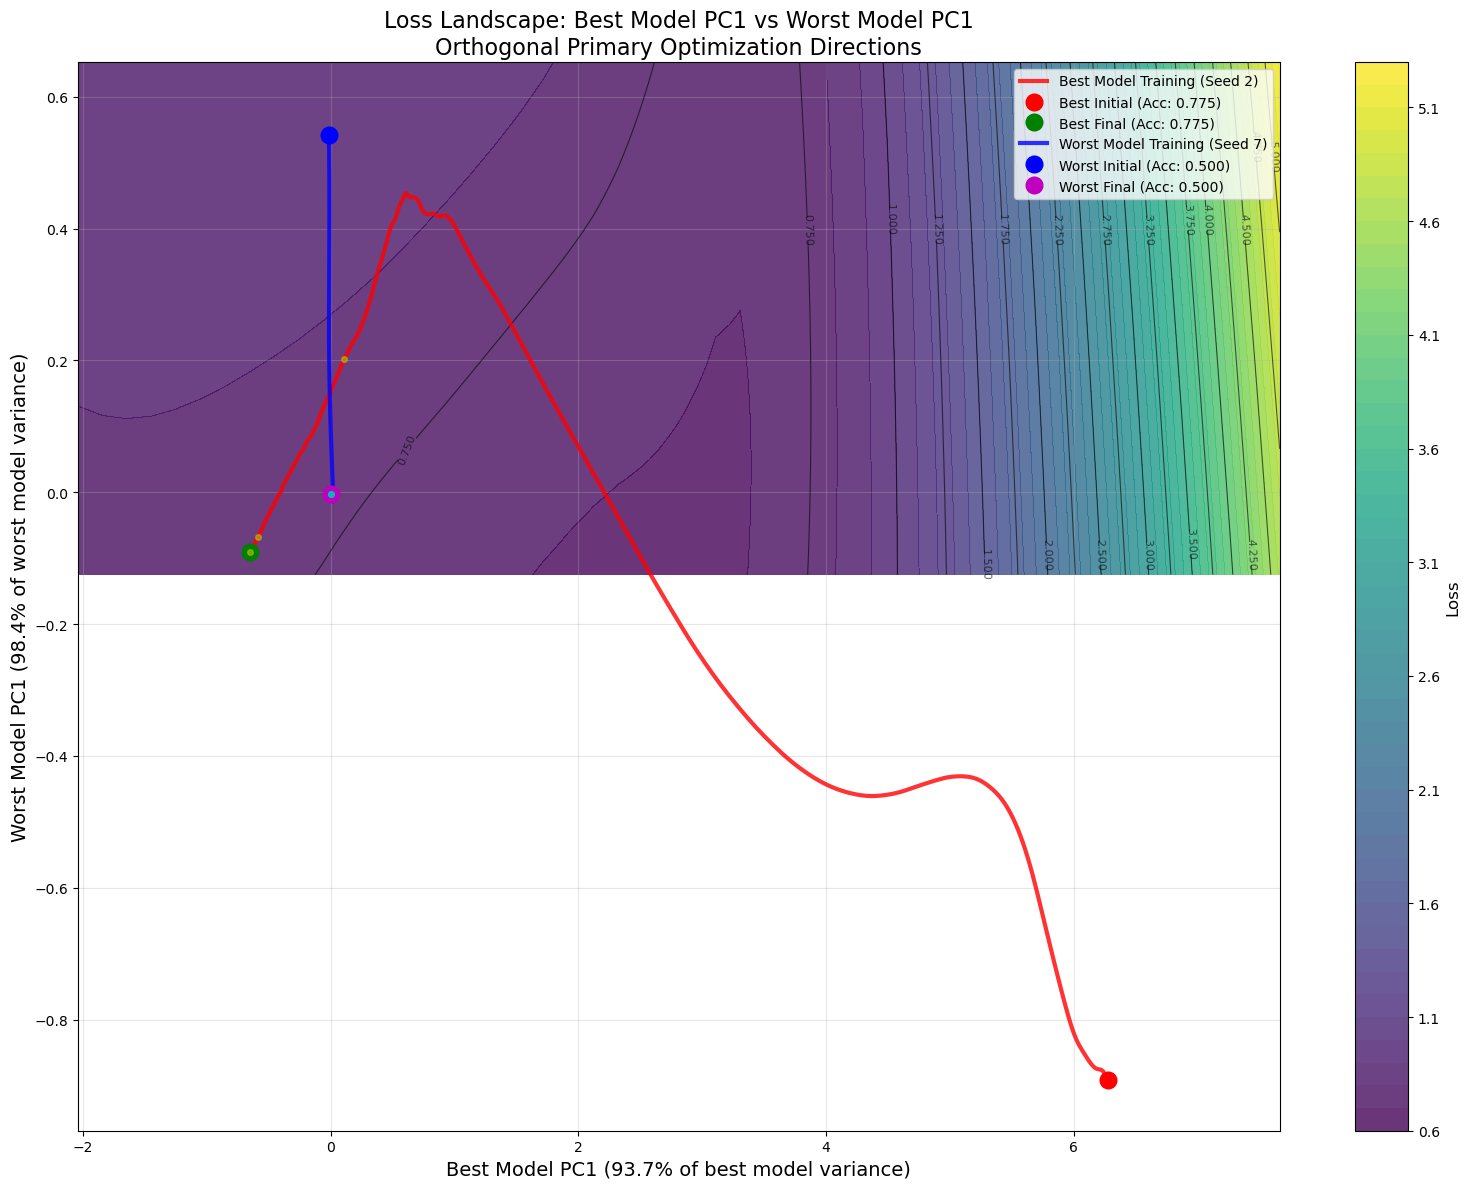


Analysis complete! Both models should now show meaningful variation along their respective axes.


In [22]:
results = run_dual_pca_analysis(
    output_dir, X_tensor, y_tensor, BaarleNet, [3]
)

---

In [23]:
def flatten_weight_dict(weight_dict):
    """
    Flatten a dictionary of weight tensors into a single 1D numpy array
    """
    flattened = []
    for name, tensor in weight_dict.items():
        if tensor is not None:
            flattened.append(tensor.cpu().numpy().flatten())
    return np.concatenate(flattened)

def unflatten_to_weight_dict(flattened_weights, reference_dict):
    """
    Convert flattened weights back to the original dictionary structure
    """
    result = {}
    start_idx = 0
    
    for name, tensor in reference_dict.items():
        if tensor is not None:
            shape = tensor.shape
            size = tensor.numel()
            
            # Extract the portion for this parameter
            param_weights = flattened_weights[start_idx:start_idx + size]
            
            # Reshape and convert to tensor
            result[name] = torch.tensor(param_weights.reshape(shape)).float()
            start_idx += size
    
    return result

def create_weight_history_matrix(training_data):
    """
    Convert weight history to a matrix where each row is a time step
    and each column is a flattened weight parameter
    """
    weights_history = training_data['weights_history']
    
    # Flatten each time step
    weight_matrix = []
    for weights in weights_history:
        flattened = flatten_weight_dict(weights)
        weight_matrix.append(flattened)
    
    return np.array(weight_matrix)

def compute_pca_directions(best_model_filepath):
    """
    Load the best model's training data and compute PCA directions
    """
    # Load the best model's training data
    with open(best_model_filepath, 'rb') as f:
        training_data = pickle.load(f)
    
    print(f"Loaded training data for seed {training_data['seed']}")
    print(f"Final accuracy: {training_data['final_accuracy']:.4f}")
    
    # Convert weight history to matrix
    weight_matrix = create_weight_history_matrix(training_data)
    print(f"Weight matrix shape: {weight_matrix.shape}")
    print(f"Total parameters: {weight_matrix.shape[1]}")
    
    # Center the data (subtract mean)
    weight_mean = np.mean(weight_matrix, axis=0)
    centered_weights = weight_matrix - weight_mean
    
    # Apply PCA
    pca = PCA()
    pca.fit(centered_weights)
    
    # Get the first two principal components
    pc1 = pca.components_[0]
    pc2 = pca.components_[1]
    
    print(f"Explained variance ratio:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
    print(f"Total (PC1 + PC2): {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]:.4f}")
    
    return pc1, pc2, weight_mean, training_data, pca

def create_pca_loss_landscape(pc1, pc2, weight_mean, reference_weights, 
                            X_tensor, y_tensor, model_class, model_args,
                            training_trajectories=None, resolution=50, output_dir=None):
    """
    Create loss landscape using PCA directions
    
    Args:
        pc1, pc2: First two principal components
        weight_mean: Mean weight vector
        reference_weights: Reference weight dict for unflattening
        training_trajectories: List of (pc1_proj, pc2_proj) tuples for trajectory bounds
        resolution: Grid resolution
    """
    
    # Create model for evaluation
    model = model_class(model_args)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Determine the range for exploration based on training trajectories
    if training_trajectories is not None:
        all_pc1 = []
        all_pc2 = []
        for pc1_proj, pc2_proj in training_trajectories:
            all_pc1.extend(pc1_proj)
            all_pc2.extend(pc2_proj)
        
        pc1_min, pc1_max = min(all_pc1), max(all_pc1)
        pc2_min, pc2_max = min(all_pc2), max(all_pc2)
        
        # Add some padding around the trajectories
        pc1_padding = (pc1_max - pc1_min) * 0.2
        pc2_padding = (pc2_max - pc2_min) * 0.2
        
        pc1_range = np.linspace(pc1_min - pc1_padding, pc1_max + pc1_padding, resolution)
        pc2_range = np.linspace(pc2_min - pc2_padding, pc2_max + pc2_padding, resolution)
        
        print(f"PC1 range: [{pc1_min - pc1_padding:.2f}, {pc1_max + pc1_padding:.2f}]")
        print(f"PC2 range: [{pc2_min - pc2_padding:.2f}, {pc2_max + pc2_padding:.2f}]")
    else:
        # Fallback to default range
        pc1_range = np.linspace(-3.0, 3.0, resolution)
        pc2_range = np.linspace(-3.0, 3.0, resolution)
    
    # Initialize loss landscape
    loss_landscape = np.zeros((resolution, resolution))
    
    print("Computing PCA-based loss landscape...")
    
    for i, alpha in enumerate(pc1_range):
        for j, beta in enumerate(pc2_range):
            # Create weight vector by moving along PC directions
            weight_vector = weight_mean + alpha * pc1 + beta * pc2
            
            # Convert back to weight dictionary format
            weight_dict = unflatten_to_weight_dict(weight_vector, reference_weights)
            
            # Set model weights and compute loss
            set_model_weights(model, weight_dict)
            loss = compute_loss_at_point(model, X_tensor, y_tensor, criterion)
            loss_landscape[j, i] = loss
        
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution}")
    
    return loss_landscape, pc1_range, pc2_range

def plot_pca_loss_landscape(loss_landscape, pc1_range, pc2_range, 
                          best_training_data, worst_training_data, pca, weight_mean, pc1, pc2,
                          output_dir=None):
    """
    Plot the PCA-based loss landscape with both training trajectories
    """
    plt.figure(figsize=(16, 12))
    
    # Create meshgrid
    X, Y = np.meshgrid(pc1_range, pc2_range)
    
    # Create contour plot
    contour = plt.contour(X, Y, loss_landscape, levels=20, colors='black', alpha=0.6, linewidths=0.8)
    contourf = plt.contourf(X, Y, loss_landscape, levels=50, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(contourf)
    cbar.set_label('Loss', fontsize=12)
    
    # Add contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Project the BEST model training trajectory onto PC space
    best_weight_matrix = create_weight_history_matrix(best_training_data)
    best_centered_weights = best_weight_matrix - weight_mean
    
    best_pc1_proj = np.dot(best_centered_weights, pc1)
    best_pc2_proj = np.dot(best_centered_weights, pc2)
    
    # Plot best model training trajectory
    plt.plot(best_pc1_proj, best_pc2_proj, 'r-', linewidth=3, alpha=0.8, label=f'Best Model Training (Seed {best_training_data["seed"]})')
    plt.plot(best_pc1_proj[0], best_pc2_proj[0], 'ro', markersize=12, label=f'Best Initial (Acc: {best_training_data["final_accuracy"]:.3f})')
    plt.plot(best_pc1_proj[-1], best_pc2_proj[-1], 'go', markersize=12, label=f'Best Final (Acc: {best_training_data["final_accuracy"]:.3f})')
    
    # Project the WORST model training trajectory onto PC space
    worst_weight_matrix = create_weight_history_matrix(worst_training_data)
    worst_centered_weights = worst_weight_matrix - weight_mean
    
    worst_pc1_proj = np.dot(worst_centered_weights, pc1)
    worst_pc2_proj = np.dot(worst_centered_weights, pc2)
    
    # Plot worst model training trajectory
    plt.plot(worst_pc1_proj, worst_pc2_proj, 'b-', linewidth=3, alpha=0.8, label=f'Worst Model Training (Seed {worst_training_data["seed"]})')
    plt.plot(worst_pc1_proj[0], worst_pc2_proj[0], 'bo', markersize=12, label=f'Worst Initial (Acc: {worst_training_data["final_accuracy"]:.3f})')
    plt.plot(worst_pc1_proj[-1], worst_pc2_proj[-1], 'mo', markersize=12, label=f'Worst Final (Acc: {worst_training_data["final_accuracy"]:.3f})')
    
    # Add some intermediate points for both trajectories
    trajectory_points = [len(best_pc1_proj)//4, len(best_pc1_proj)//2, 3*len(best_pc1_proj)//4]
    for i, point_idx in enumerate(trajectory_points):
        plt.plot(best_pc1_proj[point_idx], best_pc2_proj[point_idx], 'yo', markersize=4, alpha=0.6)
        plt.plot(worst_pc1_proj[point_idx], worst_pc2_proj[point_idx], 'co', markersize=4, alpha=0.6)
    
    # Labels and title
    explained_var = pca.explained_variance_ratio_
    plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance explained)', fontsize=14)
    plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance explained)', fontsize=14)
    plt.title(f'Loss Landscape in PCA Space\nComparing Best vs Worst Model Training Trajectories', fontsize=16)
    
    # Legend
    plt.legend(loc='best', fontsize=10)
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output directory specified
    if output_dir:
        viz_path = os.path.join(output_dir, 'loss_landscape_pca.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"PCA loss landscape saved to: {viz_path}")
    
    plt.show()
    
    return best_pc1_proj, best_pc2_proj, worst_pc1_proj, worst_pc2_proj

def compare_models_in_pca_space(best_model_data, worst_model_data, pc1, pc2, weight_mean):
    """
    Project best and worst model initial/final weights onto PCA space
    """
    models_to_compare = [
        ('Best Initial', best_model_data['initial_params'], 'ro'),
        ('Best Final', best_model_data['final_params'], 'go'), 
        ('Worst Initial', worst_model_data['initial_params'], 'bo'),
        ('Worst Final', worst_model_data['final_params'], 'mo')
    ]
    
    projections = {}
    
    for name, weights, marker in models_to_compare:
        # Flatten and center
        flattened = flatten_weight_dict(weights)
        centered = flattened - weight_mean
        
        # Project onto PCs
        pc1_proj = np.dot(centered, pc1)
        pc2_proj = np.dot(centered, pc2)
        
        projections[name] = (pc1_proj, pc2_proj)
        print(f"{name}: PC1={pc1_proj:.3f}, PC2={pc2_proj:.3f}")
    
    return projections

# Set model weights function (reused from previous code)
def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()

# Main execution function
def run_pca_analysis(output_dir, X_tensor, y_tensor, model_class, model_args):
    """
    Complete PCA analysis workflow
    """
    # Load best/worst model data
    best_worst_file = os.path.join(output_dir, "best_worst_models.pkl")
    with open(best_worst_file, 'rb') as f:
        data = pickle.load(f)
    best_model_data = data['best_model']
    worst_model_data = data['worst_model']
    
    # Find the best model's training file
    best_seed = best_model_data['seed']
    best_acc = best_model_data['accuracy']
    best_model_file = os.path.join(output_dir, f"training_data_seed_{best_seed:02d}_acc_{best_acc:.4f}.pkl")
    
    # Find the worst model's training file  
    worst_seed = worst_model_data['seed']
    worst_acc = worst_model_data['accuracy']
    worst_model_file = os.path.join(output_dir, f"training_data_seed_{worst_seed:02d}_acc_{worst_acc:.4f}.pkl")
    
    print(f"Loading best model training data from: {best_model_file}")
    print(f"Loading worst model training data from: {worst_model_file}")
    
    # Compute PCA directions from best model's training trajectory
    pc1, pc2, weight_mean, best_training_data, pca = compute_pca_directions(best_model_file)
    
    # Load worst model training data
    with open(worst_model_file, 'rb') as f:
        worst_training_data = pickle.load(f)
    
    # Get both training trajectories in PCA space to determine range
    best_weight_matrix = create_weight_history_matrix(best_training_data)
    worst_weight_matrix = create_weight_history_matrix(worst_training_data)
    
    best_centered = best_weight_matrix - weight_mean
    worst_centered = worst_weight_matrix - weight_mean
    
    best_pc1_proj = np.dot(best_centered, pc1)
    best_pc2_proj = np.dot(best_centered, pc2)
    worst_pc1_proj = np.dot(worst_centered, pc1)
    worst_pc2_proj = np.dot(worst_centered, pc2)
    
    training_trajectories = [
        (best_pc1_proj, best_pc2_proj),
        (worst_pc1_proj, worst_pc2_proj)
    ]
    
    # Create loss landscape in PCA space with expanded range
    loss_landscape, pc1_range, pc2_range = create_pca_loss_landscape(
        pc1, pc2, weight_mean, best_training_data['initial_params'],
        X_tensor, y_tensor, model_class, model_args,
        training_trajectories=training_trajectories, resolution=50, output_dir=output_dir
    )
    
    # Plot the results with both trajectories
    best_pc1_proj, best_pc2_proj, worst_pc1_proj, worst_pc2_proj = plot_pca_loss_landscape(
        loss_landscape, pc1_range, pc2_range, 
        best_training_data, worst_training_data, pca, weight_mean, pc1, pc2,
        output_dir=output_dir
    )
    
    # Compare all models in PCA space
    print("\nModel positions in PCA space:")
    projections = compare_models_in_pca_space(best_model_data, worst_model_data, pc1, pc2, weight_mean)
    
    return pc1, pc2, weight_mean, loss_landscape, projections, (best_pc1_proj, best_pc2_proj, worst_pc1_proj, worst_pc2_proj)


Loading best model training data from: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/training_data_seed_02_acc_0.7746.pkl
Loading worst model training data from: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/training_data_seed_07_acc_0.5000.pkl
Loaded training data for seed 2
Final accuracy: 0.7746
Weight matrix shape: (2500, 12)
Total parameters: 12
Explained variance ratio:
PC1: 0.9371
PC2: 0.0557
Total (PC1 + PC2): 0.9927
PC1 range: [-2.08, 7.89]
PC2 range: [-1.11, 1.91]
Computing PCA-based loss landscape...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50
PCA loss landscape saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/loss_landscape_pca.png


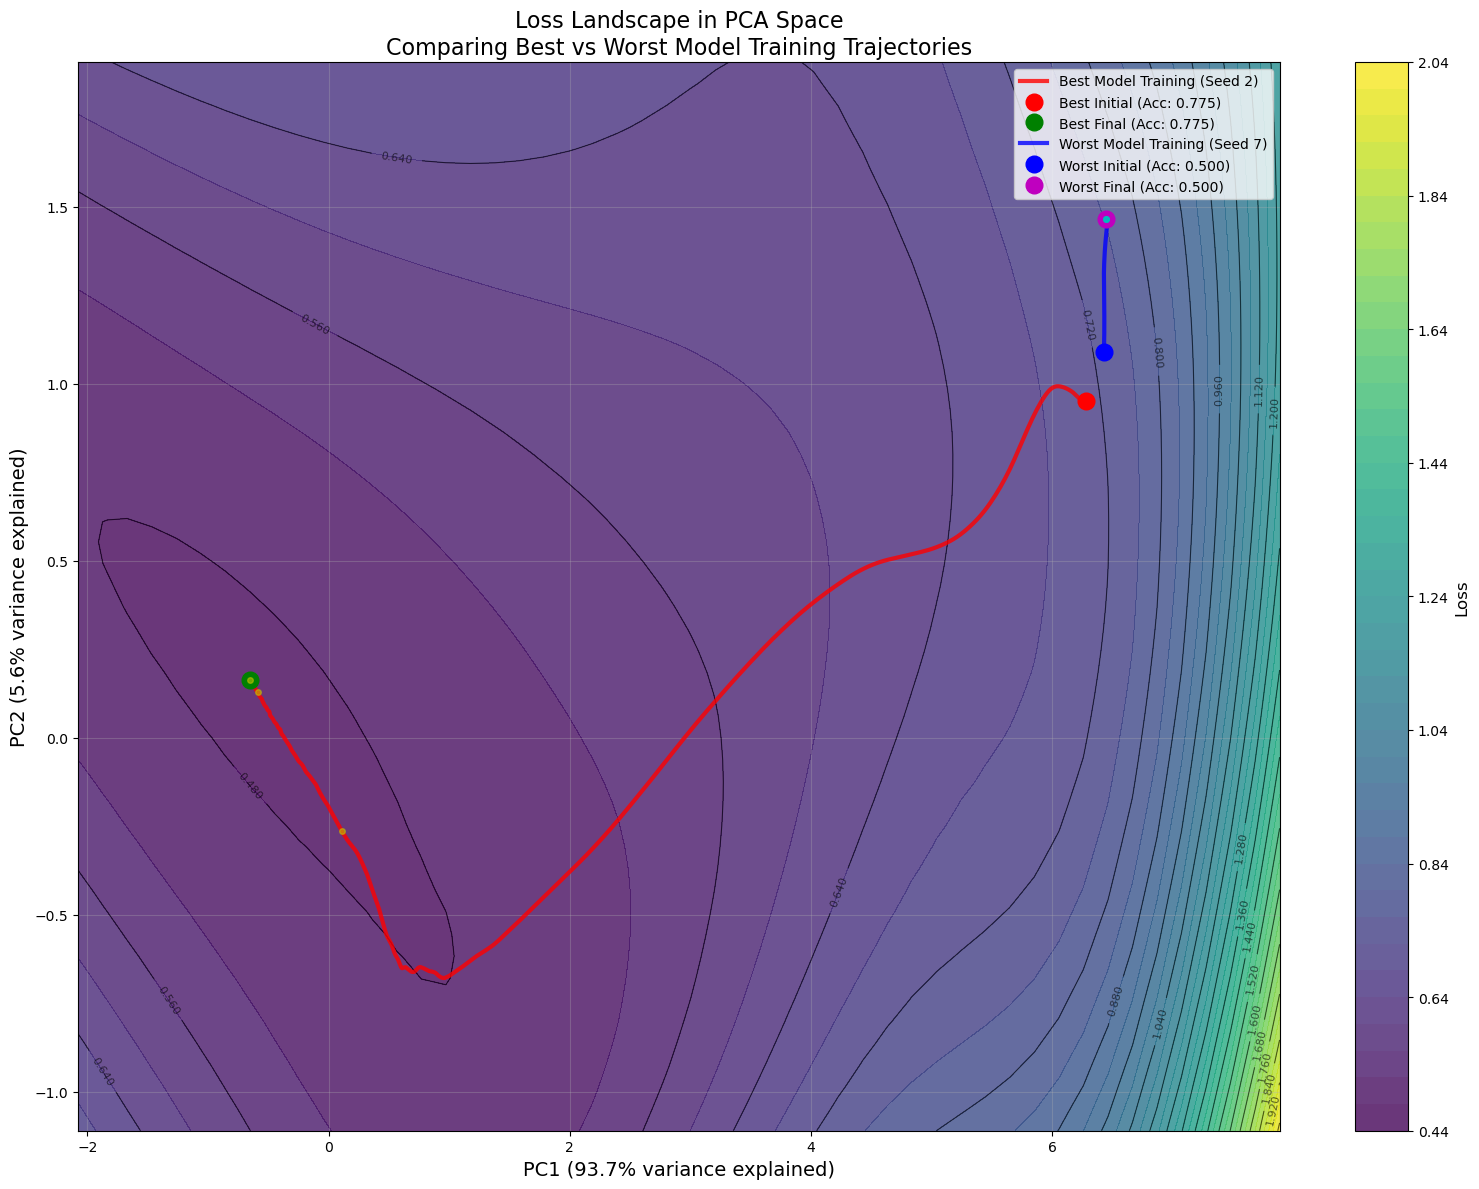


Model positions in PCA space:
Best Initial: PC1=6.277, PC2=0.951
Best Final: PC1=-0.654, PC2=0.164
Worst Initial: PC1=6.430, PC2=1.089
Worst Final: PC1=6.444, PC2=1.467


In [24]:
pc1, pc2, weight_mean, loss_landscape, projections, trajectories = run_pca_analysis(
    output_dir, X_tensor, y_tensor, BaarleNet, [3]
)

---

In [26]:
def flatten_weight_dict(weight_dict):
    """
    Flatten a dictionary of weight tensors into a single 1D numpy array
    """
    flattened = []
    for name, tensor in weight_dict.items():
        if tensor is not None:
            flattened.append(tensor.cpu().numpy().flatten())
    return np.concatenate(flattened)

def unflatten_to_weight_dict(flattened_weights, reference_dict):
    """
    Convert flattened weights back to the original dictionary structure
    """
    result = {}
    start_idx = 0
    
    for name, tensor in reference_dict.items():
        if tensor is not None:
            shape = tensor.shape
            size = tensor.numel()
            
            # Extract the portion for this parameter
            param_weights = flattened_weights[start_idx:start_idx + size]
            
            # Reshape and convert to tensor
            result[name] = torch.tensor(param_weights.reshape(shape)).float()
            start_idx += size
    
    return result

def create_weight_history_matrix(training_data):
    """
    Convert weight history to a matrix where each row is a time step
    and each column is a flattened weight parameter
    """
    weights_history = training_data['weights_history']
    
    # Flatten each time step
    weight_matrix = []
    for weights in weights_history:
        flattened = flatten_weight_dict(weights)
        weight_matrix.append(flattened)
    
    return np.array(weight_matrix)

def compute_pca_directions(best_model_filepath):
    """
    Load the best model's training data and compute PCA directions
    """
    # Load the best model's training data
    with open(best_model_filepath, 'rb') as f:
        training_data = pickle.load(f)
    
    print(f"Loaded training data for seed {training_data['seed']}")
    print(f"Final accuracy: {training_data['final_accuracy']:.4f}")
    
    # Convert weight history to matrix
    weight_matrix = create_weight_history_matrix(training_data)
    print(f"Weight matrix shape: {weight_matrix.shape}")
    print(f"Total parameters: {weight_matrix.shape[1]}")
    
    # Center the data (subtract mean)
    weight_mean = np.mean(weight_matrix, axis=0)
    centered_weights = weight_matrix - weight_mean
    
    # Apply PCA
    pca = PCA()
    pca.fit(centered_weights)
    
    # Get the first two principal components
    pc1 = pca.components_[0]
    pc2 = pca.components_[1]
    
    print(f"Explained variance ratio:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
    print(f"Total (PC1 + PC2): {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]:.4f}")
    
    return pc1, pc2, weight_mean, training_data, pca

def create_pca_loss_landscape(pc1, pc2, weight_mean, reference_weights, 
                            X_tensor, y_tensor, model_class, model_args,
                            range_factor=2.0, resolution=50, output_dir=None):
    """
    Create loss landscape using PCA directions
    
    Args:
        pc1, pc2: First two principal components
        weight_mean: Mean weight vector
        reference_weights: Reference weight dict for unflattening
        range_factor: How far to explore in each PC direction (in std devs)
        resolution: Grid resolution
    """
    
    # Create model for evaluation
    model = model_class(model_args)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Determine the range for exploration
    # Use the standard deviation of projections onto each PC
    pc1_range = np.linspace(-range_factor, range_factor, resolution)
    pc2_range = np.linspace(-range_factor, range_factor, resolution)
    
    # Initialize loss landscape
    loss_landscape = np.zeros((resolution, resolution))
    
    print("Computing PCA-based loss landscape...")
    
    for i, alpha in enumerate(pc1_range):
        for j, beta in enumerate(pc2_range):
            # Create weight vector by moving along PC directions
            weight_vector = weight_mean + alpha * pc1 + beta * pc2
            
            # Convert back to weight dictionary format
            weight_dict = unflatten_to_weight_dict(weight_vector, reference_weights)
            
            # Set model weights and compute loss
            set_model_weights(model, weight_dict)
            loss = compute_loss_at_point(model, X_tensor, y_tensor, criterion)
            loss_landscape[j, i] = loss
        
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution}")
    
    return loss_landscape, pc1_range, pc2_range

def plot_pca_loss_landscape(loss_landscape, pc1_range, pc2_range, 
                          training_data, pca, weight_mean, pc1, pc2,
                          output_dir=None):
    """
    Plot the PCA-based loss landscape with training trajectory
    """
    plt.figure(figsize=(14, 10))
    
    # Create meshgrid
    X, Y = np.meshgrid(pc1_range, pc2_range)
    
    # Create contour plot
    contour = plt.contour(X, Y, loss_landscape, levels=20, colors='black', alpha=0.6, linewidths=0.8)
    contourf = plt.contourf(X, Y, loss_landscape, levels=50, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(contourf)
    cbar.set_label('Loss', fontsize=12)
    
    # Add contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Project the training trajectory onto PC space
    weight_matrix = create_weight_history_matrix(training_data)
    centered_weights = weight_matrix - weight_mean
    
    # Project onto first two PCs
    pc1_proj = np.dot(centered_weights, pc1)
    pc2_proj = np.dot(centered_weights, pc2)
    
    # Plot training trajectory
    plt.plot(pc1_proj, pc2_proj, 'r-', linewidth=2, alpha=0.7, label='Training Trajectory')
    plt.plot(pc1_proj[0], pc2_proj[0], 'ro', markersize=10, label='Initial Weights')
    plt.plot(pc1_proj[-1], pc2_proj[-1], 'go', markersize=10, label='Final Weights')
    
    # Add some intermediate points
    trajectory_points = [len(pc1_proj)//4, len(pc1_proj)//2, 3*len(pc1_proj)//4]
    for i, point_idx in enumerate(trajectory_points):
        plt.plot(pc1_proj[point_idx], pc2_proj[point_idx], 'yo', markersize=6, alpha=0.7)
    
    # Labels and title
    explained_var = pca.explained_variance_ratio_
    plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance explained)', fontsize=12)
    plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance explained)', fontsize=12)
    plt.title(f'Loss Landscape in PCA Space\nBest Model (Seed {training_data["seed"]}, Acc: {training_data["final_accuracy"]:.3f})', fontsize=14)
    
    # Legend
    plt.legend(loc='best')
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output directory specified
    if output_dir:
        viz_path = os.path.join(output_dir, 'loss_landscape_pca.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"PCA loss landscape saved to: {viz_path}")
    
    plt.show()

def compare_models_in_pca_space(best_model_data, worst_model_data, pc1, pc2, weight_mean):
    """
    Project best and worst model initial/final weights onto PCA space
    """
    models_to_compare = [
        ('Best Initial', best_model_data['initial_params'], 'ro'),
        ('Best Final', best_model_data['final_params'], 'go'), 
        ('Worst Initial', worst_model_data['initial_params'], 'bo'),
        ('Worst Final', worst_model_data['final_params'], 'mo')
    ]
    
    projections = {}
    
    for name, weights, marker in models_to_compare:
        # Flatten and center
        flattened = flatten_weight_dict(weights)
        centered = flattened - weight_mean
        
        # Project onto PCs
        pc1_proj = np.dot(centered, pc1)
        pc2_proj = np.dot(centered, pc2)
        
        projections[name] = (pc1_proj, pc2_proj)
        print(f"{name}: PC1={pc1_proj:.3f}, PC2={pc2_proj:.3f}")
    
    return projections

# Set model weights function (reused from previous code)
def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()

# Main execution function
def run_pca_analysis(output_dir, X_tensor, y_tensor, model_class, model_args):
    """
    Complete PCA analysis workflow
    """
    # Load best/worst model data
    best_worst_file = os.path.join(output_dir, "best_worst_models.pkl")
    with open(best_worst_file, 'rb') as f:
        data = pickle.load(f)
    best_model_data = data['best_model']
    worst_model_data = data['worst_model']
    
    # Find the best model's training file
    best_seed = best_model_data['seed']
    best_acc = best_model_data['accuracy']
    best_model_file = os.path.join(output_dir, f"training_data_seed_{best_seed:02d}_acc_{best_acc:.4f}.pkl")
    
    print(f"Loading best model training data from: {best_model_file}")
    
    # Compute PCA directions from best model's training trajectory
    pc1, pc2, weight_mean, training_data, pca = compute_pca_directions(best_model_file)
    
    # Create loss landscape in PCA space
    loss_landscape, pc1_range, pc2_range = create_pca_loss_landscape(
        pc1, pc2, weight_mean, training_data['initial_params'],
        X_tensor, y_tensor, model_class, model_args,
        range_factor=3.0, resolution=50, output_dir=output_dir
    )
    
    # Plot the results
    plot_pca_loss_landscape(
        loss_landscape, pc1_range, pc2_range, 
        training_data, pca, weight_mean, pc1, pc2,
        output_dir=output_dir
    )
    
    # Compare all models in PCA space
    print("\nModel positions in PCA space:")
    projections = compare_models_in_pca_space(best_model_data, worst_model_data, pc1, pc2, weight_mean)
    
    return pc1, pc2, weight_mean, loss_landscape, projections


Loading best model training data from: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/training_data_seed_02_acc_0.7746.pkl
Loaded training data for seed 2
Final accuracy: 0.7746
Weight matrix shape: (2500, 12)
Total parameters: 12
Explained variance ratio:
PC1: 0.9371
PC2: 0.0557
Total (PC1 + PC2): 0.9927
Computing PCA-based loss landscape...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50
PCA loss landscape saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_2/loss_landscape_pca.png


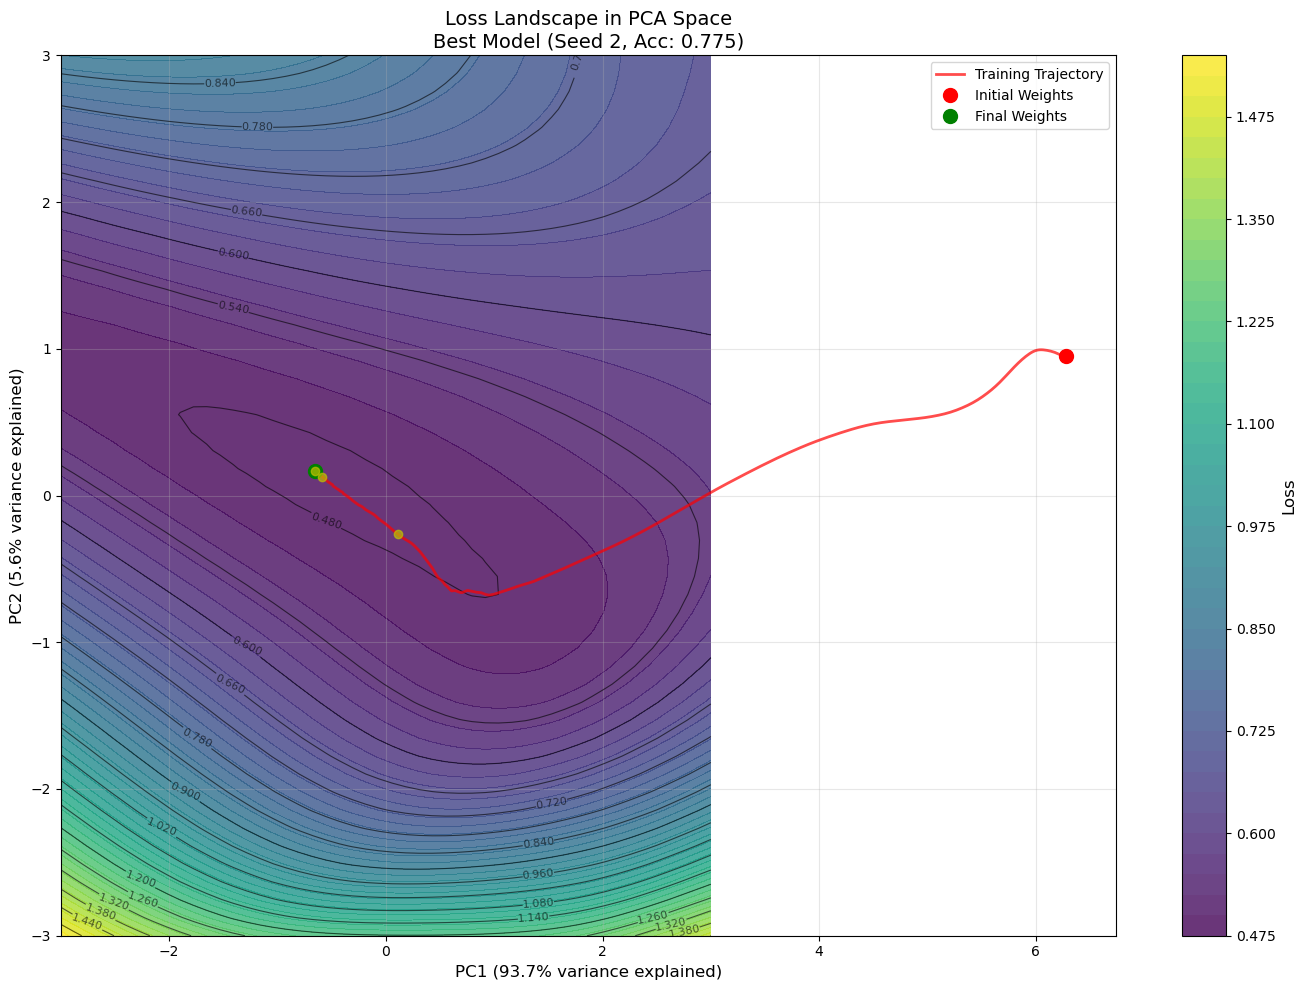


Model positions in PCA space:
Best Initial: PC1=6.277, PC2=0.951
Best Final: PC1=-0.654, PC2=0.164
Worst Initial: PC1=6.430, PC2=1.089
Worst Final: PC1=6.444, PC2=1.467


In [27]:
pc1, pc2, weight_mean, loss_landscape, projections = run_pca_analysis(
    output_dir, X_tensor, y_tensor, BaarleNet, [3])

In [ ]:
# def interpolate_weights(weights1, weights2, alpha):
#     """
#     Interpolate between two weight dictionaries
#     alpha = 0: returns weights1
#     alpha = 1: returns weights2
#     """
#     interpolated = {}
#     for name in weights1.keys():
#         interpolated[name] = (1 - alpha) * weights1[name] + alpha * weights2[name]
#     return interpolated

# def set_model_weights(model, weight_dict):
#     """Set model parameters from weight dictionary"""
#     with torch.no_grad():
#         for name, param in model.named_parameters():
#             param.data = weight_dict[name]

# def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
#     """Compute loss at current model parameters"""
#     with torch.no_grad():
#         outputs = model(X_tensor)
#         loss = criterion(outputs, y_tensor)
#         return loss.item()